In [2]:
from google.colab import drive
import pandas as pd

# 1) Drive’ı bağla
drive.mount('/content/drive')

# 2) Dosya yollarını ayarla
DATA_DIR     = '/content/drive/MyDrive/project/skindisease'
METADATA_CSV = f'{DATA_DIR}/metadata.csv'
IMAGE_DIR    = f'{DATA_DIR}/images'

# 3) Metadata’yı yükle ve kontrol et
df = pd.read_csv(METADATA_CSV)
df.head()


Mounted at /content/drive


,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NEV,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,NaN,ACK,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,NaN,ACK,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,PAT_684_1302_588.png,True


In [3]:
import pandas as pd

# Metadata zaten df değişkeninde yüklü
print(df['diagnostic'].value_counts())


diagnostic
BCC    845
ACK    730
NEV    244
SEK    235
SCC    192
MEL     52
Name: count, dtype: int64


In [4]:
# 0 = benign, 1 = malignant
df['label'] = df['diagnostic'].isin(['MEL','BCC','SCC']).astype(int)
print(df['label'].value_counts())


label
0    1209
1    1089
Name: count, dtype: int64


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 1) label’ı string’e çevir
df['label'] = df['label'].astype(str)

# 2) Train/valid ayrımı
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# 3) Data generator tanımları
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_gen = ImageDataGenerator(rescale=1./255)

# 4) Akışları oluştur
train_flow = train_gen.flow_from_dataframe(
    train_df,
    directory=IMAGE_DIR,
    x_col='img_id',
    y_col='label',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)
val_flow = val_gen.flow_from_dataframe(
    val_df,
    directory=IMAGE_DIR,
    x_col='img_id',
    y_col='label',
    target_size=(224,224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# 5) Bilgi yazdır
print(f"Train samples: {train_flow.n}, Val samples: {val_flow.n}")
print(f"Classes: {train_flow.class_indices}")


Found 644 validated image filenames belonging to 2 classes.
Found 152 validated image filenames belonging to 2 classes.
Train samples: 644, Val samples: 152
Classes: {'0': 0, '1': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1194 invalid image filename(s) in x_col="img_id". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 308 invalid image filename(s) in x_col="img_id". These filename(s) will be ignored.
  warnings.warn(


In [6]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 1) Sadece gerçek dosyası olanları tut
df = df[df['img_id'].apply(lambda x: os.path.isfile(os.path.join(IMAGE_DIR, x)))]
print(f"Filtered samples: {len(df)}")

# 2) Yeniden split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# 3) Data generator’lar (aynı ayarlar)
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest'
)
val_gen = ImageDataGenerator(rescale=1./255)

# 4) Akışları oluştur
train_flow = train_gen.flow_from_dataframe(
    train_df, directory=IMAGE_DIR, x_col='img_id', y_col='label',
    target_size=(224,224), class_mode='binary', batch_size=32, shuffle=True
)
val_flow = val_gen.flow_from_dataframe(
    val_df, directory=IMAGE_DIR, x_col='img_id', y_col='label',
    target_size=(224,224), class_mode='binary', batch_size=32, shuffle=False
)

# 5) Sonuçları yazdır
print(f"Train samples: {train_flow.n}, Val samples: {val_flow.n}")
print(f"Classes: {train_flow.class_indices}")


Filtered samples: 796
Found 636 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Train samples: 636, Val samples: 160
Classes: {'0': 0, '1': 1}


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# 1) Base model (ImageNet ön-eğitimli)
base = ResNet50(include_top=False, weights='imagenet',
                input_shape=(224,224,3))
base.trainable = False  # önce sadece başlığı eğiteceğiz

# 2) Klasifikasyon başlığı
inputs = layers.Input(shape=(224,224,3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

# 3) Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4) Model özeti
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Callback’ler
lr_plateau = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, verbose=1
)
checkpoint = ModelCheckpoint(
    'resnet_head.h5', monitor='val_accuracy', save_best_only=True, verbose=1
)

# Eğitimi başlat
history = model.fit(
    train_flow,
    epochs=5,
    validation_data=val_flow,
    callbacks=[lr_plateau, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.5963 - loss: 0.6734 
Epoch 1: val_accuracy improved from -inf to 0.71875, saving model to resnet_head.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 559s 28s/step - accuracy: 0.5980 - loss: 0.6725 - val_accuracy: 0.7188 - val_loss: 0.6079 - learning_rate: 1.0000e-04
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.7139 - loss: 0.6122
Epoch 2: val_accuracy did not improve from 0.71875
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7137 - loss: 0.6124 - val_accuracy: 0.7188 - val_loss: 0.5976 - learning_rate: 1.0000e-04
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.6978 - loss: 0.6161
Epoch 3: val_accuracy did not improve from 0.71875
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 999ms/step - accuracy: 0.6980 - loss: 0.6160 - val_accuracy: 0.7188 - val_loss: 0.5957 - learning_rate: 1.0000e-04
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.7307 - loss: 0.6020
Epoch 4: val_accuracy did not improve from 0.71875
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7302 - loss: 0.6021 - val_accuracy: 0.7188 - val_loss: 0.5957 - learning_rate: 1.0000e-04
Epoch 5/5
20/20

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# 1) Bazı katmanları aç
base.trainable = True
for layer in base.layers[:-15]:
    layer.trainable = False

# 2) Modeli yeniden derle
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 3) Callback’ler
lr_plateau = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, verbose=1
)
checkpoint_ft = ModelCheckpoint(
    'resnet_finetuned.h5', monitor='val_accuracy', save_best_only=True, verbose=1
)

# 4) Fine-tuning eğitimi
history_ft = model.fit(
    train_flow,
    epochs=8,
    validation_data=val_flow,
    callbacks=[lr_plateau, checkpoint_ft]
)


Epoch 1/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.6814 - loss: 0.6297
Epoch 1: val_accuracy improved from -inf to 0.71875, saving model to resnet_finetuned.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6829 - loss: 0.6283 - val_accuracy: 0.7188 - val_loss: 0.5951 - learning_rate: 1.0000e-05
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.7113 - loss: 0.5798
Epoch 2: val_accuracy did not improve from 0.71875
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7116 - loss: 0.5797 - val_accuracy: 0.7188 - val_loss: 0.5945 - learning_rate: 1.0000e-05
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.7457 - loss: 0.5682
Epoch 3: val_accuracy did not improve from 0.71875
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7451 - loss: 0.5681 - val_accuracy: 0.7188 - val_loss: 0.5935 - learning_rate: 1.0000e-05
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.7314 - loss: 0.5800
Epoch 4: val_accuracy did not improve from 0.71875
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7323 - loss: 0.5788 - val_accuracy: 0.7188 - val_loss: 0.5930 - learning_rate: 1.0000e-05
Epoch 5/8
20/20 ━━━━

              precision    recall  f1-score   support

      benign       0.72      1.00      0.84       115
   malignant       0.00      0.00      0.00        45

    accuracy                           0.72       160
   macro avg       0.36      0.50      0.42       160
weighted avg       0.52      0.72      0.60       160



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


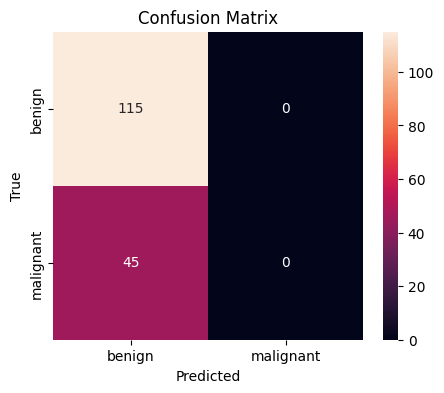

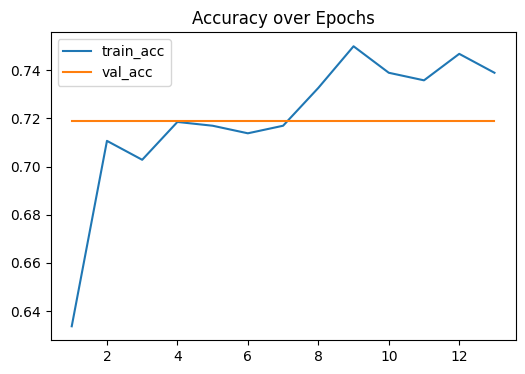

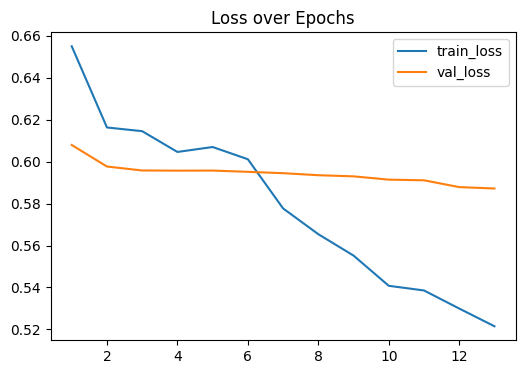

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# 1) En iyi modeli yükle
best_model = load_model('resnet_finetuned.h5')

# 2) Val setini predict et
val_flow.reset()
y_true = np.array(val_flow.labels).astype(int)

y_pred_prob = best_model.predict(val_flow, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# 3) Classification report
print(classification_report(y_true, y_pred, target_names=['benign','malignant']))

# 4) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['benign','malignant'],
            yticklabels=['benign','malignant'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# 5) Eğitim & validation eğri grafikleri
acc = history.history['accuracy'] + history_ft.history['accuracy']
val_acc = history.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history.history['loss'] + history_ft.history['loss']
val_loss = history.history['val_loss'] + history_ft.history['val_loss']
epochs = range(1, len(acc)+1)

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, label='train_acc')
plt.plot(epochs, val_acc, label='val_acc')
plt.title('Accuracy over Epochs'); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss over Epochs'); plt.legend(); plt.show()


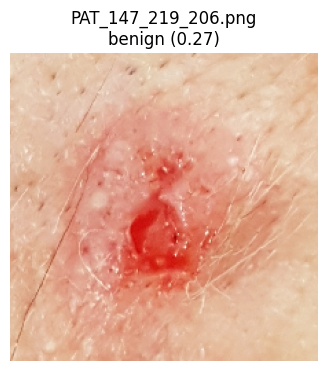

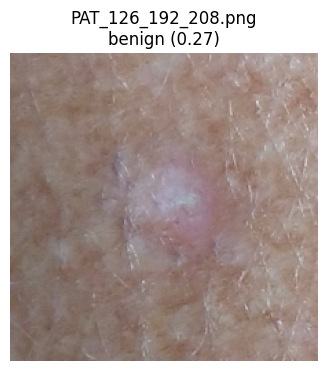

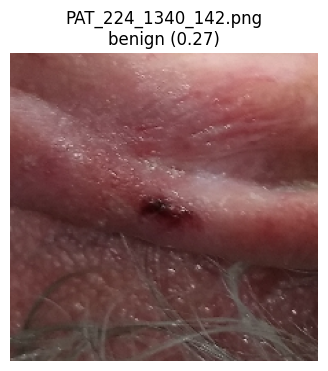

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# 1) En iyi modeli tekrar yükleyelim
best_model = load_model('resnet_finetuned.h5')

# 2) Val_df’den rastgele 3 resim seç
test_imgs = val_df['img_id'].sample(3, random_state=42).tolist()

for img_name in test_imgs:
    img_path = os.path.join(IMAGE_DIR, img_name)
    # Görseli yükle & ölçeklendir
    img = load_img(img_path, target_size=(224,224))
    arr = img_to_array(img) / 255.0

    # Tahmin
    prob = best_model.predict(np.expand_dims(arr, 0), verbose=0)[0,0]
    label = 'malignant' if prob > 0.5 else 'benign'

    # Görseli çiz
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"{img_name}\n{label} ({prob:.2f})")
    plt.axis('off')

plt.show()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 333s 16s/step - accuracy: 0.6492 - loss: 1.0053 - val_accuracy: 0.7188 - val_loss: 0.5977
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 988ms/step - accuracy: 0.7309 - loss: 0.6052 - val_accuracy: 0.7188 - val_loss: 0.6148
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 981ms/step - accuracy: 0.7101 - loss: 0.6096 - val_accuracy: 0.7250 - val_loss: 0.5982
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 983ms/step - accuracy: 0.7156 - loss: 0.5908 - val_accuracy: 0.7000 - val_loss: 0.5782
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 977ms/step - accuracy: 0.7317 - loss: 0.5896 - val_accuracy: 0.7625 - val_loss: 0.5479
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 988ms/step - accuracy: 0.7575 - loss: 0.5436 - val_accuracy: 0.7625 - val_loss: 0.5435
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 985ms/step - accuracy: 0.7493 - loss: 0.5663 - val_accuracy: 0.7250 - val_loss: 0.5861
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 995ms/step - accuracy: 0.7254 - loss: 0.6107 - val_accur

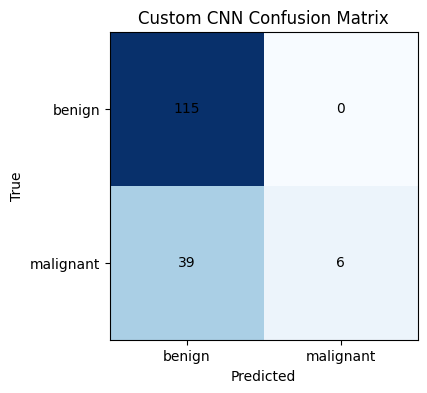

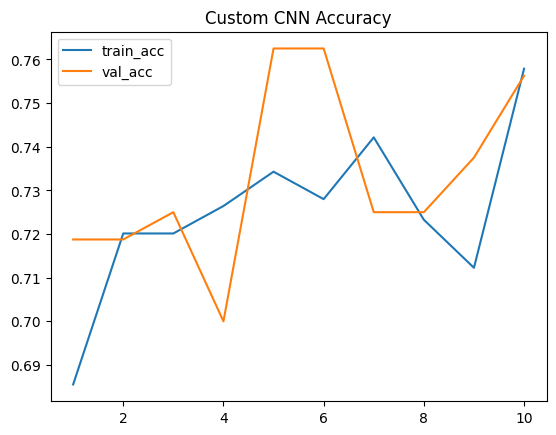

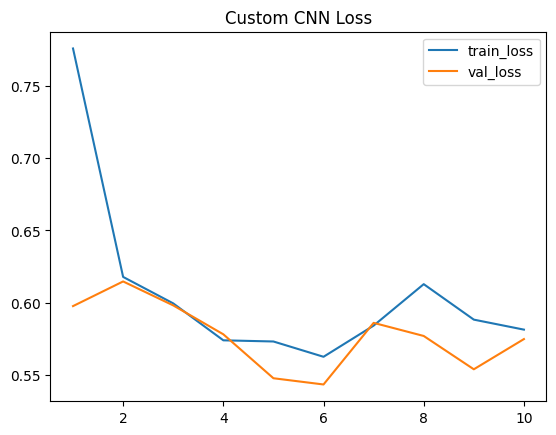

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 1) Custom CNN mimarisi
model_cnn = models.Sequential([
    layers.Input(shape=(224,224,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

# 2) Eğitimi başlat
history_cnn = model_cnn.fit(
    train_flow,
    epochs=10,
    validation_data=val_flow
)

# 3) Performans metrikleri
val_flow.reset()
y_true = np.array(val_flow.labels).astype(int)
y_pred = (model_cnn.predict(val_flow) > 0.5).astype(int).reshape(-1)

print(classification_report(y_true, y_pred, target_names=['benign','malignant']))

# 4) Confusion matrix görsellemesi
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.xticks([0,1], ['benign','malignant'])
plt.yticks([0,1], ['benign','malignant'])
for i in (0,1):
    for j in (0,1):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Custom CNN Confusion Matrix')
plt.show()

# 5) Eğitim & validation eğri grafikleri
epochs = range(1, len(history_cnn.history['accuracy'])+1)
plt.figure()
plt.plot(epochs, history_cnn.history['accuracy'], label='train_acc')
plt.plot(epochs, history_cnn.history['val_accuracy'], label='val_acc')
plt.title('Custom CNN Accuracy'); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history_cnn.history['loss'], label='train_loss')
plt.plot(epochs, history_cnn.history['val_loss'], label='val_loss')
plt.title('Custom CNN Loss'); plt.legend(); plt.show()


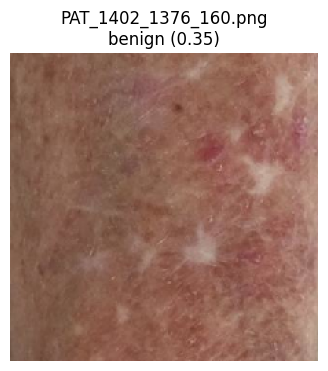

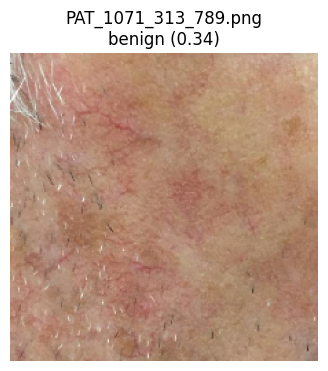

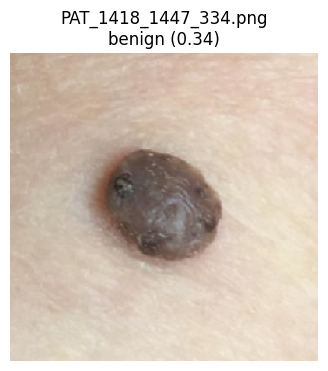

In [10]:

import os, numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# 1) Üç test görseli seç (aynı val_df’den)
test_imgs = val_df['img_id'].sample(3, random_state=99).tolist()
for img_name in test_imgs:
 img_path = os.path.join(IMAGE_DIR, img_name)
 img = load_img(img_path, target_size=(224,224))
 arr = img_to_array(img) / 255.0
 prob = model_cnn.predict(np.expand_dims(arr,0), verbose=0)[0,0]
 label = 'malignant' if prob>0.5 else 'benign'
 plt.figure(figsize=(4,4))
 plt.imshow(img); plt.axis('off')
 plt.title(f"{img_name}\n{label} ({prob:.2f})")
plt.show()
